# Visual-Bar dataset

1. Define the random variables $U_i$ where $i$ ranges from 1 to 5:

$$U_1, U_2 \sim \text{Uniform}(0,1)$$

$$U_3, U_4, U_5 \sim \mathcal{N}(0,1)$$

2. Generate hidden binary variables $H_1$ and $H_2$ based on $U_1$ and $U_2$:

$$H_1 = \mathbf{1}_{U_1 < 0.5}$$

$$H_2 = \mathbf{1}_{U_2 < 0.5}$$

3. The image variables Vbar and Hbar are defined based on $H_1$, $H_2$, $U_3$, and $U_4$:

$$Vbar = f_{V}(H1, U_3) = H1 \text{ OR } (U_3 > \text{noise\_threshold})$$

$$Hbar = f_{H}(H2, U_4) = H2 \text{ OR } (U_4 > \text{noise\_threshold})$$

The existence of a vertical bar Vbar in the image is determined by $H_1$ or the noise $U_3$ exceeding a threshold. Similarly, the existence of a horizontal bar Hbar in the image is determined by $H_2$ or the noise $U_4$ exceeding a threshold.

4. The target variable $T$ is defined based on $H1$, Hbar, and $U_5$:

$$T = f_{T}(H1, Hbar, U_5) = (H1 \text{ AND } (U_5 > \text{t\_h1\_threshold})) \text{ OR } (Hbar \text{ AND } (U_5 > \text{t\_hbar\_threshold}))$$

The value of $T$ is determined by the existence of H1 and Hbar and the noise $U_5$ exceeding a specific threshold.

## Generate Noise Images

In [211]:
import numpy as np

# Define parameters
im_shape = (10, 10)
N = 1000000
noise_lvl = 0.1

# Set a random seed for reproducibility
np.random.seed(0)

# Initialize images with noise
X_images = np.random.random((N, im_shape[0], im_shape[1])) < noise_lvl
X_images = X_images.astype('float32')

In [212]:
# Show 10 images by random samples
import matplotlib.pyplot as plt

def display_random_images(X_images, N, n_images=10):
    """
    Display random images from the given array of images.
    
    Parameters:
    X_images (numpy.array): An array of images.
    N (int): The total number of images from which to select.
    n_images (int, optional): The number of images to display. Defaults to 10.
    
    Returns:
    None
    """
    # Select random images
    indices = np.random.choice(N, n_images, replace=False)
    selected_images = X_images[indices]

    # Determine grid shape
    grid_shape = (n_images // 5, 5) if n_images > 5 else (1, n_images)

    # Plot images
    fig, axes = plt.subplots(*grid_shape, figsize=(10, 4))

    if n_images > 1:
        for i, ax in enumerate(axes.flat):
            ax.imshow(selected_images[i], cmap='gray')
            ax.axis('off')
    else:
        axes.imshow(selected_images[0], cmap='gray')
        axes.axis('off')

    plt.tight_layout()
    plt.show()

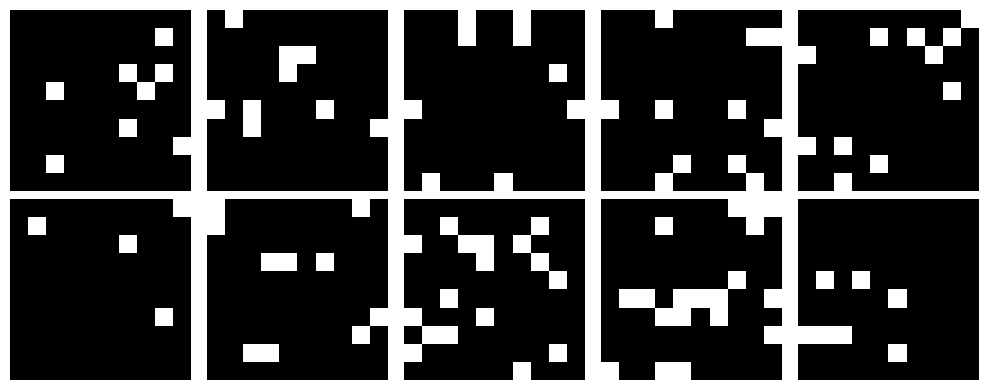

In [213]:
display_random_images(X_images, N)

## Generate H1/H2 Hidden Variables

In [214]:
# sample H1, H2 from uniform dist with p=0.5

def generate_samples(n):
    return np.where(np.random.uniform(size=n) < 0.5, 1, 0)

# Generate 2500 H1 random variables
h1 = generate_samples(N)
print(h1)

# Generate 2500 H2 random variables
h2 = generate_samples(N)
print(h2)

[0 1 1 ... 0 0 1]
[1 1 0 ... 1 1 0]


## Generate Vertical/Horizontal Bars

In [215]:
# Define noise threshold
noise_threshold = 0.5

# Generate U3 and U4 for each sample
U3 = np.random.normal(0, 1, N)
U4 = np.random.normal(0, 1, N)

# For each sample, generate Hbar and Vbar
Hbar = (h2 == 1) | (U4 > noise_threshold)
Vbar = (h1 == 1) | (U3 > noise_threshold)

# For each sample, add vertical bar if Vbar[i] == 1
# and horizontal bar if Hbar[i] == 1
for i in range(N):
    if Vbar[i]:
        # Add vertical bar in the middle of the image
        X_images[i, :, im_shape[1] // 2] = 1
    if Hbar[i]:
        # Add horizontal bar in the middle of the image
        X_images[i, im_shape[0] // 2, :] = 1

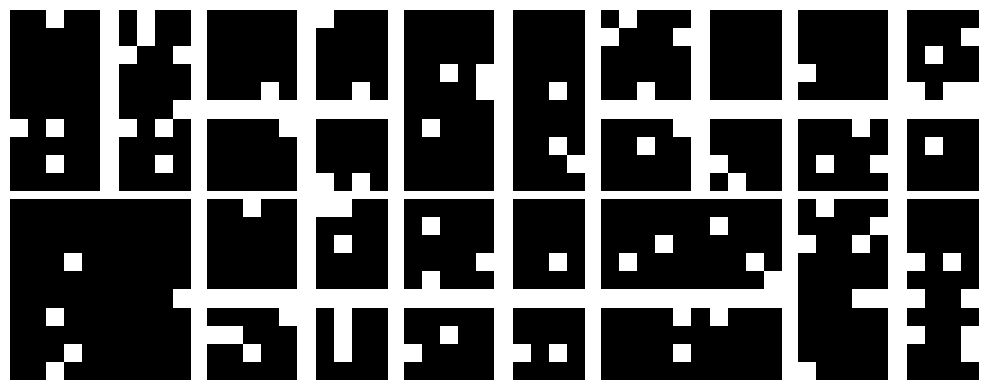

In [216]:
display_random_images(X_images, N)

## Generate Target Variables

In [217]:
def generate_T(h1, Hbar, U5):
    # Define thresholds
    T_h1_threshold = 0.5
    T_hbar_threshold = 0.5

    # Compute T
    T = np.logical_or(np.logical_and(h1, U5 > T_h1_threshold), np.logical_and(Hbar, U5 > T_hbar_threshold))

    return T

# Generate U5 for each sample
U5 = np.random.normal(0, 1, N)

# Use the function to generate T
T = generate_T(h1, Hbar, U5)

print(T)

[False False False ...  True False False]


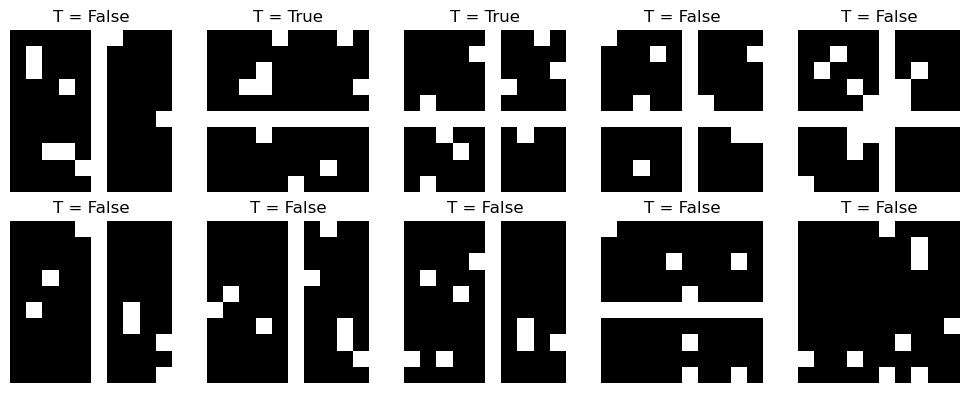

In [218]:
# Select 10 random indices
indices = np.random.choice(N, 10, replace=False)
selected_images = X_images[indices]
selected_T = T[indices]

# Plot images with corresponding T values
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    ax.imshow(selected_images[i], cmap='gray')
    ax.set_title(f'T = {selected_T[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [219]:
print(Vbar)
print(Hbar)

[False  True  True ...  True False  True]
[ True  True False ...  True  True False]


In [220]:
# Compute expected value of T when Vbar is present
Vbar_present = Vbar
T_Vbar_present = T[Vbar_present].mean()

# Compute expected value of T when Vbar is absent
Vbar_absent = ~Vbar
T_Vbar_absent = T[Vbar_absent].mean()

# Compute expected value of T when Hbar is present
Hbar_present = Hbar
T_Hbar_present = T[Hbar_present].mean()

# Compute expected value of T when Hbar is absent
Hbar_absent = ~Hbar
T_Hbar_absent = T[Hbar_absent].mean()

print("E[T|Vbar=1]: ", T_Vbar_present)
print("E[T|Vbar=0]: ", T_Vbar_absent)

# compute the difference between E[T|Vbar=1] and E[T|Vbar=0]
print("E[T|Vbar=1] - E[T|Vbar=0]: ", T_Vbar_present - T_Vbar_absent)

print("E[T|Hbar=1]: ", T_Hbar_present)
print("E[T|Hbar=0]: ", T_Hbar_absent)

# compute the difference between E[T|Hbar=1] and E[T|Hbar=0]
print("E[T|Hbar=1] - E[T|Hbar=0]: ", T_Hbar_present - T_Hbar_absent)

E[T|Vbar=1]:  0.2828959339672986
E[T|Vbar=0]:  0.2016467208637626
E[T|Vbar=1] - E[T|Vbar=0]:  0.08124921310353603
E[T|Hbar=1]:  0.30836076829094866
E[T|Hbar=0]:  0.15352181464559328
E[T|Hbar=1] - E[T|Hbar=0]:  0.15483895364535538


In [221]:
# Convert boolean arrays to integer arrays for correlation computation
Vbar_int = Vbar.astype(int)
T_int = T.astype(int)

# Compute and print the correlation
correlation_Vbar_T = np.corrcoef(Vbar_int, T_int)[0, 1]
print("Correlation between Vbar and T: ", correlation_Vbar_T)

Correlation between Vbar and T:  0.08870053801403331


## Interventional Distribution

- Intervention doesn't affect the causal upstream (parent)

### Vbar

In case of intervening on Vbar, interventing doesn't affect $h_1$ because $h_1$ is upstream of Vbar.

In [222]:
# Simulate data under do(Vbar=1) and do(Vbar=0)
Vbar_do_1 = np.ones(N, dtype=bool) # not gonna be used in T gen
Vbar_do_0 = np.zeros(N, dtype=bool) # not gonna be used in T gen

# Generate T for these interventions
T_Vbar_do_1 = generate_T(h1, Hbar, U5)
T_Vbar_do_0 = generate_T(h1, Hbar, U5)

# Compute interventional expectations
E_T_Vbar_do_1 = T_Vbar_do_1.mean()
E_T_Vbar_do_0 = T_Vbar_do_0.mean()

print("E[T|do(Vbar=1)]: ", E_T_Vbar_do_1)
print("E[T|do(Vbar=0)]: ", E_T_Vbar_do_0)

# compute the difference between E[T|do(Vbar=1)] and E[T|do(Vbar=0)]
print("E[T|do(Vbar=1)] - E[T|do(Vbar=0)]: ", E_T_Vbar_do_1 - E_T_Vbar_do_0)

E[T|do(Vbar=1)]:  0.254782
E[T|do(Vbar=0)]:  0.254782
E[T|do(Vbar=1)] - E[T|do(Vbar=0)]:  0.0


In [223]:
# Simulate data under do(Hbar=1) and do(Hbar=0)
Hbar_do_1 = np.ones(N, dtype=bool)
Hbar_do_0 = np.zeros(N, dtype=bool)

# Generate T for these interventions
T_Hbar_do_1 = generate_T(h1, Hbar_do_1, U5)
T_Hbar_do_0 = generate_T(h1, Hbar_do_0, U5)

# Compute interventional expectations
E_T_Hbar_do_1 = T_Hbar_do_1.mean()
E_T_Hbar_do_0 = T_Hbar_do_0.mean()

print("E[T|do(Hbar=1)]: ", E_T_Hbar_do_1)
print("E[T|do(Hbar=0)]: ", E_T_Hbar_do_0)

# compute the difference between E[T|do(Hbar=1)] and E[T|do(Hbar=0)]
print("E[T|do(Hbar=1)] - E[T|do(Hbar=0)]: ", E_T_Hbar_do_1 - E_T_Hbar_do_0)

E[T|do(Hbar=1)]:  0.308431
E[T|do(Hbar=0)]:  0.154306
E[T|do(Hbar=1)] - E[T|do(Hbar=0)]:  0.154125
